In [1]:
import numpy as np
import Terms 
import celerite2
import matplotlib.pyplot as plt
import sys
sys.path.append('Llamaradas-Estelares')
import Flare_model as fm

In [2]:
def gauss(x, sigma, t0):
    return np.exp(-(x - t0)**2 / (2 * sigma**2))

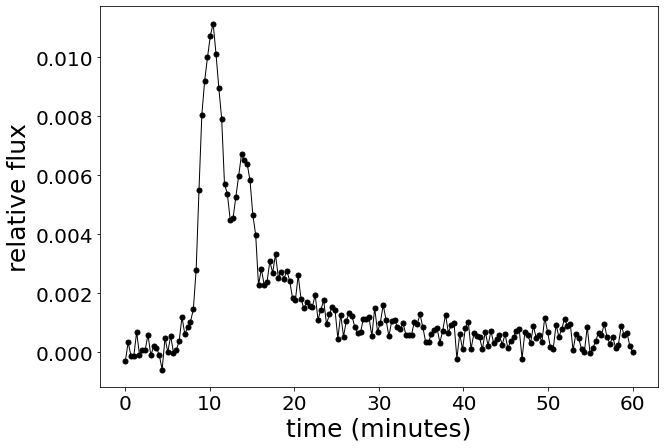

In [3]:
plt.figure(figsize=(10, 7))
t = np.linspace(0, 60, 60*3)
flare = fm.flare_model(t, 10, 5, 0.01)

k = Terms.NSTerm(celerite2.terms.SHOTerm(rho=4, tau=100, sigma=0.002), lambda x: gauss(x, 4, 14))
gp = celerite2.GaussianProcess(k, t, diag=1e-7)
noise = gp.sample()

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('time (minutes)', fontsize=25)
plt.ylabel('relative flux', fontsize=25)

plt.plot(t, flare + noise, 'ko', markersize=5)
plt.plot(t, flare + noise, 'k-', linewidth=1)

y = flare + noise

plt.savefig('/Users/tgordon/Desktop/flare_demo.pdf')

In [4]:
from scipy.optimize import minimize

def buildgp(params):
    
    logdiag, peak, fwhm, height, rho, logtau, logamp, mu, sigma = params
    
    k = Terms.NSTerm(
        celerite2.terms.SHOTerm(
            rho=rho, 
            tau=np.exp(logtau), 
            sigma=np.exp(logamp)
        ), 
        lambda x: gauss(x, mu, sigma)
    )
    gp = celerite2.GaussianProcess(
        k, 
        t, 
        mean=fm.flare_model(t, peak, fwhm, height), 
        diag=np.exp(logdiag)
    )
    return gp


def neg_log_like(params):
    try:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
    except:
        ll = -np.inf
    return -ll


initial_params = [np.log(1e-7), 10, 5, 0.01, 4, np.log(100), np.log(0.002), 4, 14]
soln = minimize(neg_log_like, initial_params)

In [5]:
import emcee

def prior(params):
    
    logdiag, peak, fwhm, height, rho, logtau, logamp, mu, sigma = params
    
    if ((peak > 0) 
        & (fwhm > 0) 
        & (height > 0) 
        & (rho > 0) 
        & (mu > 0)
        & (sigma > 0) 
        & (logtau < 10)
        & (logamp < 10)
       ):
        return 0.0
    else:
        return -np.inf
    

def log_prob(params):
    
    pr = prior(params)
    if pr == 0.0:
        gp = buildgp(params)
        ll = gp.log_likelihood(y)
        if not np.isnan(ll):
            return ll
        else:
            return - np.inf
    else:
        return -np.inf

In [6]:
init = initial_params
coords = init + 1e-5 * np.random.randn(64, len(init))
sampler = emcee.EnsembleSampler(
    coords.shape[0], coords.shape[1], log_prob
)
state = sampler.run_mcmc(coords, 5000, progress=True)
sampler.reset()
state = sampler.run_mcmc(state, 10000, progress=True)

100%|██████████| 10000/10000 [03:22<00:00, 49.27it/s]


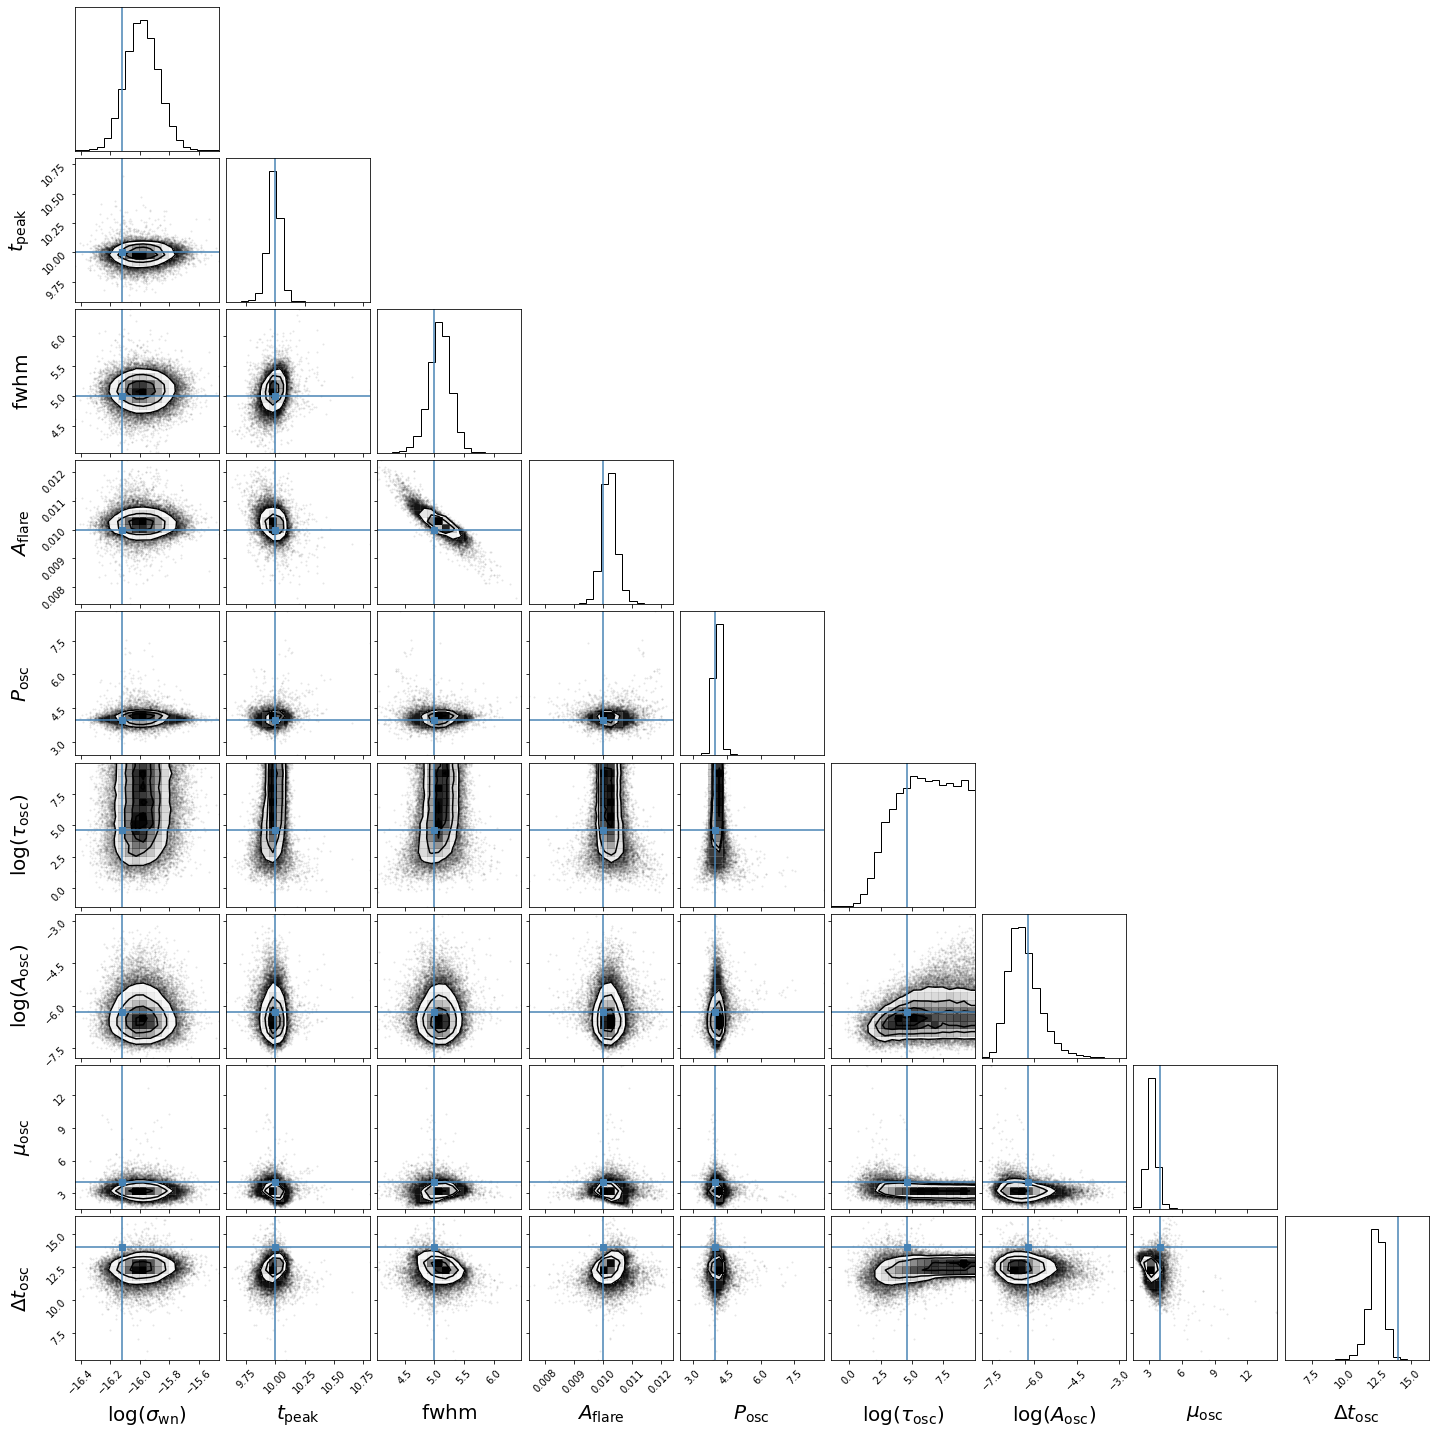

In [7]:
import corner 
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
truths = initial_params
labels=[r'$\log(\sigma_\mathrm{wn})$', r'$t_\mathrm{peak}$', 
        r'$\mathrm{fwhm}$', r'$A_\mathrm{flare}$', r'$P_\mathrm{osc}$', 
        r'$\mathrm{log}(\tau_\mathrm{osc})$', r'$\mathrm{log}(A_\mathrm{osc})$', r'$\mu_\mathrm{osc}$', r'$\Delta t_\mathrm{osc}$']

fig = corner.corner(flat_samples, truths=truths, labels=labels, label_kwargs={'fontsize': 20});
plt.savefig('/Users/tgordon/Desktop/flare_corner.pdf')

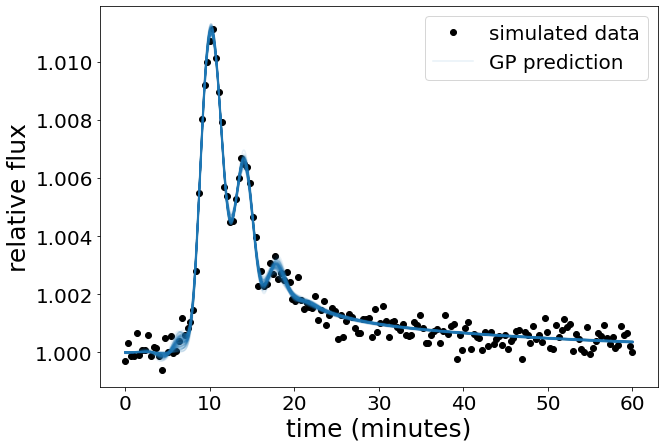

In [8]:
plt.figure(figsize=(10, 7))
plt.plot(t, flare + noise + 1, 'ko', label='simulated data')
xx = np.linspace(t.min(), t.max(), 1000)

for sample in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    gp = buildgp(sample)
    prediction = gp.predict(flare + noise, t=xx, include_mean=False)
    _, peak, fwhm, height, _, _, _, _, _ = sample
    
    flare_only = fm.flare_model(xx, peak, fwhm, height)
    prediction += flare_only
    plt.plot(xx, prediction + 1, color="C0", alpha=0.1)
    #plt.plot(t, flare_only, color='r', alpha=0.1)
    
plt.plot(xx, prediction + 1, color="C0", alpha=0.1, label='GP prediction')
plt.legend(fontsize=20)
    
#plt.plot(t, flare, 'k--', linewidth=3)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('time (minutes)', fontsize=25)
plt.ylabel('relative flux', fontsize=25)
plt.savefig('/Users/tgordon/Desktop/flare_predict.pdf')

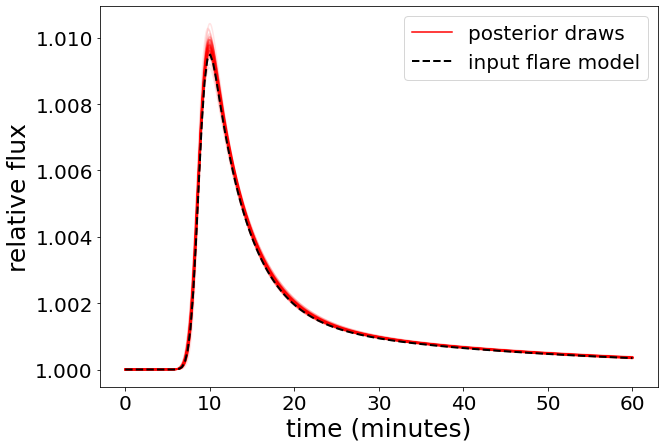

In [9]:
plt.figure(figsize=(10, 7))

for sample in flat_samples[np.random.randint(len(flat_samples), size=100)]:
    gp = buildgp(sample)
    #prediction = gp.predict(flare + noise, t)
    _, peak, fwhm, height, _, _, _, _, _ = sample
    
    flare_only = fm.flare_model(xx, peak, fwhm, height)
    #plt.plot(t, prediction, color="C0", alpha=0.1)
    plt.plot(xx, flare_only + 1, color='r', alpha=0.1)
    
plt.plot(xx[0:1], flare_only[0:1] + 1, color='r', alpha=1.0, label='posterior draws')

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('time (minutes)', fontsize=25)
plt.ylabel('relative flux', fontsize=25)
plt.plot(t, flare + 1, 'k--', linewidth=2, label='input flare model')
plt.legend(fontsize=20)
plt.savefig('/Users/tgordon/Desktop/flare_only.pdf')